In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")
# Explore the columns of data and find outliers
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict, Any, Union, Callable, Optional
import tqdm
from sklearn.isotonic import IsotonicRegression


In [2]:
import sys
sys.path.append("..")

from source.utils.visualization import *
from source.utils.preprocessing import *
from source.utils.regions import get_charts_by_region, get_regional_charts_delta_rank, calculate_popularity_metrics

SAVE_EXTENSION = '.pdf'
SAVE_DIR = '../figures/'

plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 1,
    "usetex" : False
}

setup_plotting_icml2022(
    **plot_kwargs
    )


In [3]:
REFRESH_DATA = True
CHARTS_PATH = '../data/charts_processed.csv'
AUDIO_PATH = '../data/audio_features_processed.csv'

In [4]:
if REFRESH_DATA:
    # Load the datasets into dataframes. Read the date column as datetime.date
    charts_df = pd.read_csv(CHARTS_PATH, parse_dates=['date'])

charts_df['date'] = pd.to_datetime(charts_df['date'])

# Display the first few rows of the DataFrame to verify
charts_df.head()

,title,rank,date,artist,url,region,chart,trend,streams
0,Chantaje (feat. Maluma),1,2017-01-01,Shakira,https://open.spotify.com/track/6mICuAdrwEjh6Y6...,Argentina,top200,SAME_POSITION,253019.0
1,Vente Pa' Ca (feat. Maluma),2,2017-01-01,Ricky Martin,https://open.spotify.com/track/7DM4BPaS7uofFul...,Argentina,top200,MOVE_UP,223988.0
2,Reggaetón Lento (Bailemos),3,2017-01-01,CNCO,https://open.spotify.com/track/3AEZUABDXNtecAO...,Argentina,top200,MOVE_DOWN,210943.0
3,Safari,4,2017-01-01,"J Balvin, Pharrell Williams, BIA, Sky",https://open.spotify.com/track/6rQSrBHf7HlZjtc...,Argentina,top200,SAME_POSITION,173865.0
4,Shaky Shaky,5,2017-01-01,Daddy Yankee,https://open.spotify.com/track/58IL315gMSTD37D...,Argentina,top200,MOVE_UP,153956.0


In [5]:
if REFRESH_DATA:
    # Load the audio features dataset
    audio_df = pd.read_csv(AUDIO_PATH)
    # Change the column-name of 'id' to 'track_id' to match the charts_df
    audio_df.rename(columns={'id': 'track_id'}, inplace=True)

audio_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,track_id
0,0.18700,0.852,195840,0.773,0.000030,8,0.1590,-2.921,0,0.0776,102.034,4,0.907,6mICuAdrwEjh6Y6lroV2Kg
1,0.00431,0.663,259196,0.920,0.000017,11,0.1010,-4.070,0,0.2260,99.935,4,0.533,7DM4BPaS7uofFul3ywMe46
2,0.40000,0.761,222560,0.838,0.000000,4,0.1760,-3.073,0,0.0502,93.974,4,0.710,3AEZUABDXNtecAOSC1qTfo
3,0.55100,0.508,205600,0.687,0.000003,0,0.1260,-4.361,1,0.3260,180.044,4,0.555,6rQSrBHf7HlZjtcMZ4S4bO
4,0.07600,0.899,234320,0.626,0.000000,6,0.0631,-4.228,0,0.2920,88.007,4,0.873,58IL315gMSTD37DOZPJ2hf


In [6]:
# For now only restrict the dataset to top200 charts for stream/ranking analysis.
charts_df = charts_df[charts_df["chart"] == "top200"]
charts_df["track_id"] = charts_df["url"].apply(lambda x: x.split("/")[-1])

## Correlations
In the previous notebook, a popularity metric is defined for a track and we explored the correlation between audio features and the songs. This notebook investigates and considers the result of correlation analysis qualitively and quantitively.

In [7]:
from source.utils.regions import get_charts_by_region,calculate_popularity_metrics
from scipy.stats import kendalltau, spearmanr, pearsonr
def get_region_correlations(region : str,
                            date : Union[str, Tuple[str,str]],
                            charts_df : pd.DataFrame,
                            audio_df : pd.DataFrame,
                            delta_k = 200,
                            correlation_column : str = 'weighted_popularity'
                            ) -> pd.DataFrame:
    """
    Get the correlation between the audio features and the chart position for a given region.
    """
    test_df = calculate_popularity_metrics(
        get_charts_by_region(charts_df, region),
        date,
        delta_k = delta_k,
    )

    test_df['weighted_popularity'] = test_df['popularity'] * test_df['average_stream_proportion']
    test_df_joined = test_df[['track_id',correlation_column]].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id")

    # Get the correliatons usning scipy
    corr_dict = {}
    spearman_corr_dict = {}
    kendal_corr_dict = {}
    for col in audio_df.columns:
        if col == 'track_id':
            continue
        corr = pearsonr(test_df_joined[correlation_column], test_df_joined[col])
        spearman_corr = spearmanr(test_df_joined[correlation_column], test_df_joined[col])
        kendal_corr = kendalltau(test_df_joined[correlation_column], test_df_joined[col])

        corr_dict[col] = corr
        spearman_corr_dict[col] = spearman_corr
        kendal_corr_dict[col] = kendal_corr

    # Make the values of dict Series to be compatible
    corr_dict = pd.DataFrame(corr_dict, index=['corr', 'p-value']).T
    spearman_corr_dict = pd.DataFrame(spearman_corr_dict, index=['corr', 'p-value']).T
    kendal_corr_dict = pd.DataFrame(kendal_corr_dict, index=['corr', 'p-value']).T
    
    return corr_dict, spearman_corr_dict, kendal_corr_dict

delta_k = 200
COI = "weighted_popularity"
corrs_dict = {}
for unique_region in tqdm.tqdm(charts_df['region'].unique(), desc="Processing regions"):
    corrs = get_region_correlations(unique_region,
                                    ("2017-01-01", "2022-01-01"),
                                    charts_df, audio_df,
                                    delta_k = delta_k,
                                    correlation_column = COI)
    # Save it to a dictionary
    corrs_dict[unique_region] = corrs


Processing regions: 100%|██████████| 69/69 [02:04<00:00,  1.81s/it]


In [8]:
# Save the dictionary to a pickle file
import pickle
with open(f'correlations_2017_2022_{COI}_with_p_value.pickle', 'wb') as handle:
    pickle.dump(corrs_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [9]:
spearman_corrs = {}
spearman_corrs_p = {}
for k,v in corrs_dict.items():
    spearman_corrs[k] = v[1]["corr"]
    spearman_corrs_p[k] = v[1]["p-value"]

# Create a dataframe for p-values and correlations
spearman_df_corrs = pd.concat(spearman_corrs, axis=1)
spearman_df_corrs_p = pd.concat(spearman_corrs_p, axis=1)
spearman_df_corrs_p.max(axis=1).sort_values(ascending=True)


danceability        0.385034
speechiness         0.840672
energy              0.842320
valence             0.864455
mode                0.925939
loudness            0.936914
acousticness        0.937615
duration_ms         0.973478
key                 0.980407
liveness            0.983861
instrumentalness    0.988043
tempo               0.990166
time_signature      0.998669
dtype: float64

The hypothesis of the Spearman rank correlation is:
$$
H_0 : \textnormal{There is no correlation between features}
$$
For small p-values, we can reject the hypothesis to show that there is a correlation where as for high p-values, we can not reject the non-existence of the correlation. For our casse, we have a lot of weak-correlation (defined as $|\rho| > 0.1$)

In [10]:
# How many regions have a p-value of less than 0.05?
alpha = 0.05
spearman_df_corrs_p[spearman_df_corrs_p < alpha].count(axis=1).sort_values(ascending=False)

danceability        66
loudness            61
instrumentalness    57
valence             48
energy              46
speechiness         44
liveness            40
duration_ms         36
mode                36
acousticness        29
time_signature      28
tempo               15
key                  9
dtype: int64

In [11]:
# Get the min/max of the rows and their columns
min_corr, max_corr, min_abs = spearman_df_corrs.min(axis=1), spearman_df_corrs.max(axis=1), spearman_df_corrs.abs().min(axis=1)
min_corr_idx, max_corr_idx, min_abs_idx = spearman_df_corrs.idxmin(axis=1), spearman_df_corrs.idxmax(axis=1), spearman_df_corrs.abs().idxmin(axis=1)
min_corr_p_values, max_corr_p_value, min_abs_corr_p_value = spearman_df_corrs_p[min_corr_idx.values], spearman_df_corrs_p[max_corr_idx.values], spearman_df_corrs_p[min_abs_idx.values]

# Create a dataframe
empty_df = pd.DataFrame(index=spearman_df_corrs.index)
empty_df["min_corr"] = min_corr
empty_df["min_corr_idx"] = min_corr_idx
empty_df["max_corr_idx"] = max_corr_idx
empty_df["min_abs_corr_idx"] = min_abs_idx
min_corr_p_values_list = []
max_corr_p_values_list = []
abs_corr_p_values_list = []
for idx, row in empty_df.iterrows():
    min_corr_p_values_list.append(spearman_df_corrs_p.loc[idx, row['min_corr_idx']])
    max_corr_p_values_list.append(spearman_df_corrs_p.loc[idx, row['max_corr_idx']])
    abs_corr_p_values_list.append(spearman_df_corrs_p.loc[idx, row['min_abs_corr_idx']])
    
empty_df["max_corr"] = max_corr
empty_df["min_abs_corr"] = min_abs
empty_df['min_corr_p_values'] = min_corr_p_values_list
empty_df['max_corr_p_values'] = max_corr_p_values_list
empty_df['min_abs_corr_p_values'] = abs_corr_p_values_list

empty_df = empty_df[['max_corr_idx','max_corr', 'max_corr_p_values','min_corr_idx','min_corr', 'min_corr_p_values','min_abs_corr_idx','min_abs_corr', 'min_abs_corr_p_values']]

#All values should be :.3f
empty_df['min_corr'] = empty_df['min_corr'].apply(lambda x: f"{x:.3f}")
empty_df['max_corr'] = empty_df['max_corr'].apply(lambda x: f"{x:.3f}")
empty_df['min_corr_p_values'] = empty_df['min_corr_p_values'].apply(lambda x: f"{x:.3e}")
empty_df['max_corr_p_values'] = empty_df['max_corr_p_values'].apply(lambda x: f"{x:.3e}")
empty_df.sort_values(by="max_corr", inplace=True, ascending=False)

empty_df

,max_corr_idx,max_corr,max_corr_p_values,min_corr_idx,min_corr,min_corr_p_values,min_abs_corr_idx,min_abs_corr,min_abs_corr_p_values
loudness,Nicaragua,0.384,8.912e-73,Indonesia,-0.075,1.739e-06,Taiwan,0.000826,0.936914
danceability,Nicaragua,0.342,2.861e-57,Switzerland,0.014,1.390e-01,Switzerland,0.014344,0.138998
speechiness,Nicaragua,0.284,2.321e-39,Morocco,-0.103,4.592e-08,Austria,0.002121,0.840672
energy,Nicaragua,0.255,7.876e-32,Indonesia,-0.122,8.281e-15,Czech Republic,0.003754,0.753698
valence,Brazil,0.210,3.966e-49,Indonesia,-0.035,2.474e-02,Australia,0.002298,0.864455
acousticness,Indonesia,0.124,2.379e-15,Luxembourg,-0.159,9.734e-10,Netherlands,0.000821,0.937615
time_signature,Chile,0.098,3.249e-11,Morocco,-0.013,5.076e-01,Saudi Arabia,0.000031,0.998669
tempo,Brazil,0.096,2.390e-11,Netherlands,-0.042,5.754e-05,Philippines,0.000195,0.990166
duration_ms,Spain,0.083,2.839e-10,Brazil,-0.188,1.477e-39,India,0.000665,0.973478
liveness,Brazil,0.068,2.706e-06,Philippines,-0.079,5.120e-07,Poland,0.000242,0.983861


The table shows that Nicaragua is an interesting country as it has a lot of correlated audio features. However as the correlation reaches $0$, we have
a lot of p-values that is higher than the $\alpha$. Is this the case for weakly correlated features?

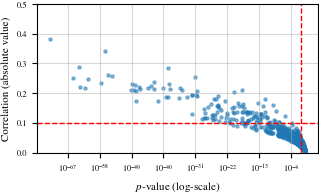

In [12]:
# Concatante each cell into a one-dimensional array
spearman_df_corrs_flat = np.abs(spearman_df_corrs.values.flatten())
spearman_corrs_p_flat = spearman_df_corrs_p.values.flatten()


plt.scatter(spearman_corrs_p_flat,spearman_df_corrs_flat, s=5, alpha=0.5)

# draw a horizontal line at alpha = 0.05 dashed
plt.axvline(x=0.05, color='r', linestyle='--', label=r'$\alpha = 0.05$',linewidth=1)
plt.axhline(y=0.10, color='r', linestyle='--', label=r'$\rho = 0.10$',linewidth=1)

# Set the x-axis to be log-scale
plt.xscale('log')
# Change x-ticks;
plt.yticks(np.arange(0, 1.05, 0.10))

plt.ylim(0, 0.5)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.xlabel("$p$-value (log-scale)")
plt.ylabel("Correlation (absolute value)")

plt.savefig(f"{SAVE_DIR}correlation_vs_p_value{SAVE_EXTENSION}", bbox_inches='tight', dpi=300)


It seems that all of our correlations is *significantly important*, as the top-right region of the plot is empty which indicates that there is no weakly-correlated value with high p-value. To see the effect of the correlation, we compare the loudness feautre with biggest and least correlated countries.

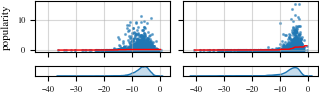

In [13]:
def plot_popularity_metrics(charts_df : pd.DataFrame,
                            audio_df : pd.DataFrame, 
                            region : str,
                            date_range : Tuple[str, str],
                            metric_column : str,
                            audio_feature_column : str,
                            delta_k : int = 200, 
                            save_dir : Optional[str] = None,
                            scatter_ax=None,
                            kde_ax=None):
    
    if metric_column in ["delta_rank","streams"] :
        test_df = get_regional_charts_delta_rank(
            get_charts_by_region(charts_df,region=region),
            date_range,
        )

        test_df_joined = test_df[['track_id',metric_column]].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id")

    elif metric_column in ["weighted_popularity", "popularity"]:
        test_df = calculate_popularity_metrics(
        get_charts_by_region(charts_df, region),
        date_range,
        delta_k = delta_k)

        test_df['weighted_popularity'] = test_df['popularity'] * test_df['average_stream_proportion']
        test_df_joined = test_df[['track_id',metric_column]].join(audio_df.set_index('track_id'), on='track_id').drop_duplicates(subset="track_id")

    if scatter_ax is None and kde_ax is None:
        fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [8, 1]}, sharex=True)
        scatter_ax, kde_ax = axs

    # Scatter plot on the first subplot
    scatter_ax.scatter(test_df_joined[audio_feature_column],test_df_joined[metric_column], alpha=0.5, s = 1.5)
    scatter_ax.set_ylabel(metric_column if metric_column != "weighted_popularity" else "popularity")
    scatter_ax.grid(alpha=0.5)

    # KDE plot on the second subplot
    sns.kdeplot(x=test_df_joined[audio_feature_column], ax=kde_ax, shade=True, bw_adjust=.5)
    kde_ax.set_xlabel(audio_feature_column)
    kde_ax.set_ylabel("density")
    kde_ax.grid(alpha=0.5)
    
    regressor = IsotonicRegression()
    X = test_df_joined[audio_feature_column].values
    y = test_df_joined[metric_column].values
    regressor.fit(X, y)

    # # Plot the isotonic regression
    X_test = np.linspace(X.min(), X.max(), 300)
    y_test = regressor.predict(X_test)
    scatter_ax.plot(X_test, y_test, linewidth=1, color="red", label="isotonic regression")
    scatter_ax.legend()


plot_kwargs = {
    "column" : "half",
    "nrows" : 1,
    "ncols" : 2,
    "usetex" : False
}
reset_plottings(**plot_kwargs)   

fig, axes = plt.subplots(nrows=2, ncols=2, gridspec_kw={'height_ratios': [5, 1]},
                         sharex=True, sharey="row") 

plot_popularity_metrics(
    charts_df,
    audio_df,
    region="Taiwan",
    date_range=("2017-01-01", "2022-01-01"),
    metric_column="weighted_popularity",
    audio_feature_column="loudness",
    save_dir=SAVE_DIR,
    scatter_ax=axes[0, 0],
    kde_ax=axes[1, 0]
)

plot_popularity_metrics(
    charts_df,
    audio_df,
    region="Nicaragua",
    date_range=("2017-01-01", "2022-01-01"),
    metric_column="weighted_popularity",
    audio_feature_column="loudness",
    save_dir=SAVE_DIR,
    scatter_ax=axes[0, 1],
    kde_ax=axes[1, 1]
)    
axes[0, 1].set_ylabel("")
axes[1, 1].set_ylabel("")
axes[1, 0].set_ylabel("")
axes[0, 0].set_xlabel("")
axes[1, 0].set_xlabel("")
axes[0, 1].set_xlabel("")
axes[1, 1].set_xlabel("")

# Do not display the legend
axes[0, 0].legend().set_visible(False)
axes[0, 1].legend().set_visible(False)

axes[1, 0].set_yticks([])

# Align the y-labels on the same x-axis
fig.align_ylabels(axes[:, 0])

plt.savefig(os.path.join(SAVE_DIR, f"loudness_vs_weighted_popularity.pdf"), bbox_inches='tight', dpi=300)
plt.show()


This ends our small-exploration of qualitive-quantitive analysis of the hypothesis! This notebook explores that the correlations we found are statistically significant and highly correlated plots corresponds for steeper increase of the isometric regression result!